In [284]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [285]:
df_2014 = pd.read_csv('./new_data/2014_US_exchange.csv', index_col=0)
df_2015 = pd.read_csv('./new_data/2015_US_exchange.csv', index_col=0)
df_2016 = pd.read_csv('./new_data/2016_US_exchange.csv', index_col=0)
df_2017 = pd.read_csv('./new_data/2017_US_exchange.csv', index_col=0)
df_2018 = pd.read_csv('./new_data/2018_US_exchange.csv', index_col=0)

In [286]:
df_2014.rename(columns={"2015 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df_2015.rename(columns={"2016 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df_2016.rename(columns={"2017 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df_2017.rename(columns={"2018 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df_2018.rename(columns={"2019 PRICE VAR [%]": "PRICE_VAR"},inplace=True)

In [287]:
# Rename the train, validation and test sets
train = pd.concat([df_2014, df_2015, df_2016])
val = df_2017
test = df_2018
print(train.shape)
print(val.shape)
print(test.shape)

(10087, 225)
(3741, 225)
(3288, 225)


In [288]:
train["Sector"].value_counts()

Financial Services        2237
Technology                1490
Industrials               1350
Healthcare                1203
Consumer Cyclical         1185
Energy                     571
Basic Materials            559
Real Estate                557
Consumer Defensive         447
Utilities                  272
Communication Services     216
Name: Sector, dtype: int64

In [289]:
print(train.columns.values)
#interesting categories: 'effectiveTaxRate', 'Sector', 'Market Cap'
#these are interesting because they are "meta" attributes, 
train = train.filter(items=['effectiveTaxRate', 'Sector', 'Market Cap', 'Class'])

['Symbol' 'Revenue' 'Revenue Growth' 'Cost of Revenue' 'Gross Profit'
 'R&D Expenses' 'SG&A Expense' 'Operating Expenses' 'Operating Income'
 'Interest Expense' 'Earnings before Tax' 'Income Tax Expense'
 'Net Income - Non-Controlling int' 'Net Income - Discontinued ops'
 'Net Income' 'Preferred Dividends' 'Net Income Com' 'EPS' 'EPS Diluted'
 'Weighted Average Shs Out' 'Weighted Average Shs Out (Dil)'
 'Dividend per Share' 'Gross Margin' 'EBITDA Margin' 'EBIT Margin'
 'Profit Margin' 'Free Cash Flow margin' 'EBITDA' 'EBIT'
 'Consolidated Income' 'Earnings Before Tax Margin' 'Net Profit Margin'
 'Cash and cash equivalents' 'Short-term investments'
 'Cash and short-term investments' 'Receivables' 'Inventories'
 'Total current assets' 'Property, Plant & Equipment Net'
 'Goodwill and Intangible Assets' 'Long-term investments' 'Tax assets'
 'Total non-current assets' 'Total assets' 'Payables' 'Short-term debt'
 'Total current liabilities' 'Long-term debt' 'Total debt'
 'Deferred revenue' '

In [290]:
print(train.shape)
train.dropna(inplace=True)
#6573 is still sufficient data, dropna will be fine
print(max(train["effectiveTaxRate"]))
print(min(train["effectiveTaxRate"]))
#but we have some crazy tax values. Should be between 0 and 1

(10087, 4)
207.08333333333
-100.4358974359


In [291]:
train = train[train['effectiveTaxRate'] < 1]
train = train[train['effectiveTaxRate'] >= 0]
print(max(train["effectiveTaxRate"]))
print(min(train["effectiveTaxRate"]))

0.98788199964671
0.0


Text(0, 0.5, 'Frequency')

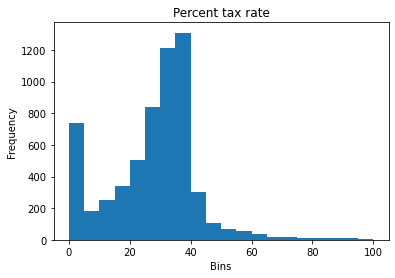

In [292]:
train['effectiveTaxRateInt'] = train['effectiveTaxRate']*100
train['effectiveTaxRateInt'] = train['effectiveTaxRateInt'].map(lambda x: int(x))
data = list(train['effectiveTaxRateInt'])
binsize = 5
plt.hist(data, bins=range(min(data), max(data) + binsize, binsize))

plt.title('Percent tax rate')
plt.xlabel("Bins")
plt.ylabel("Frequency")

In [293]:
#now its time to clean market cap.
train = train[train['Market Cap'] > 0]
print(max(train["Market Cap"]))
print(min(train["Market Cap"]))
#seems fine as 1 700 000 000 000 is amazon in 2021
#our largest is   88 164 240 000

96192000000000.0
582860.98


Text(0, 0.5, 'Frequency')

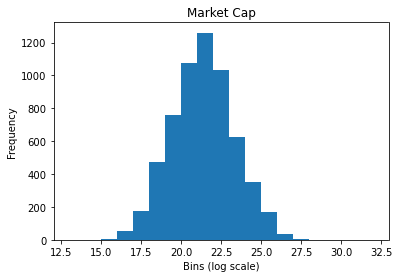

In [294]:
train["Market Cap log"] = np.log(train["Market Cap"])
train["Market Cap log"] = train['Market Cap log'].map(lambda x: int(x))
data = list(train['Market Cap log'])
binsize = 1
plt.hist(data, bins=range(min(data), max(data) + binsize, binsize))

plt.title("Market Cap")
plt.xlabel("Bins (log scale)")
plt.ylabel("Frequency")
#its perfectly gaussian!

In [295]:
#must convert categories to a categorical encoding so that gauss can work on it.
train["Sector"] = train["Sector"].astype('category')
train["SectorNo"] = train["Sector"].cat.codes
#since I have discreteized the values into ints, its time to remove the continuous data
train_train = train.filter(items=['effectiveTaxRateInt', 'SectorNo', 'Market Cap log'])#, 'Class'])
train_answer_key = train.filter(items=['Class'])

In [296]:
#validation will be done on 2017
#i need to do all operations on val that I did to train
val.dropna()
val = val[val['effectiveTaxRate'] < 1]
val = val[val['effectiveTaxRate'] >= 0]
val['effectiveTaxRateInt'] = val['effectiveTaxRate']*100
val['effectiveTaxRateInt'] = val['effectiveTaxRateInt'].map(lambda x: int(x))

val = val[val['Market Cap'] > 0]
val["Market Cap log"] = np.log(val["Market Cap"])
val["Market Cap log"] = val['Market Cap log'].map(lambda x: int(x))
val["Sector"] = val["Sector"].astype('category')
val["SectorNo"] = val["Sector"].cat.codes

val_test = val.filter(items = ['Class'])
val_train = val.filter(items = ['effectiveTaxRateInt', 'SectorNo', 'Market Cap log'])

In [297]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
naive_bayes = MultinomialNB()
naive_bayes.fit(train_train, train_answer_key.values.ravel())
naive_bayes2 = GaussianNB()
naive_bayes2.fit(train_train, train_answer_key.values.ravel())

GaussianNB()

In [298]:
predictionsMN = naive_bayes.predict(val_train)
predictionsGA = naive_bayes2.predict(val_train)

In [299]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Test Confusion Matrix MN: ")
print(confusion_matrix(val_test, predictionsMN))
print('Accuracy score Multinomal: {}'.format(accuracy_score(val_test, predictionsMN)))
print('Precision score Multinomal: {}'.format(precision_score(val_test, predictionsMN)))
print('Recall score Multinomal: {}'.format(recall_score(val_test, predictionsMN)))
print('F1 score Multinomal: {}'.format(f1_score(val_test, predictionsMN)))

print("Test Confusion Matrix GA: ")
print(confusion_matrix(val_test, predictionsGA))
print('Accuracy score Gaussian: {}'.format(accuracy_score(val_test, predictionsGA)))
print('Precision score Gaussian: {}'.format(precision_score(val_test, predictionsGA)))
print('Recall score Gaussian: {}'.format(recall_score(val_test, predictionsGA)))
print('F1 score Gaussian: {}'.format(f1_score(val_test, predictionsGA)))

Test Confusion Matrix MN: 
[[  12 1273]
 [   4  509]]
Accuracy score Multinomal: 0.28976640711902113
Precision score Multinomal: 0.2856341189674523
Recall score Multinomal: 0.9922027290448343
F1 score Multinomal: 0.44357298474945533
Test Confusion Matrix GA: 
[[  57 1228]
 [  14  499]]
Accuracy score Gaussian: 0.3092324805339266
Precision score Gaussian: 0.2889403590040533
Recall score Gaussian: 0.9727095516569201
F1 score Gaussian: 0.44553571428571437


In [300]:
#and now for test results on 2018 data
test.dropna()
test = test[test['effectiveTaxRate'] < 1]
test = test[test['effectiveTaxRate'] >= 0]
test['effectiveTaxRateInt'] = test['effectiveTaxRate']*100
test['effectiveTaxRateInt'] = test['effectiveTaxRateInt'].map(lambda x: int(x))

test = test[test['Market Cap'] > 0]
test["Market Cap log"] = np.log(test["Market Cap"])
test["Market Cap log"] = test['Market Cap log'].map(lambda x: int(x))
test["Sector"] = test["Sector"].astype('category')
test["SectorNo"] = test["Sector"].cat.codes

test_test = test.filter(items = ['Class'])
test_train = test.filter(items = ['effectiveTaxRateInt', 'SectorNo', 'Market Cap log'])

In [301]:
predictionsMN = naive_bayes.predict(test_train)
predictionsGA = naive_bayes2.predict(test_train)

In [302]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Test Confusion Matrix MN: ")
print(confusion_matrix(test_test, predictionsMN))
print('Accuracy score Multinomal: {}'.format(accuracy_score(test_test, predictionsMN)))
print('Precision score Multinomal: {}'.format(precision_score(test_test, predictionsMN)))
print('Recall score Multinomal: {}'.format(recall_score(test_test, predictionsMN)))
print('F1 score Multinomal: {}'.format(f1_score(test_test, predictionsMN)))

print("Test Confusion Matrix GA: ")
print(confusion_matrix(test_test, predictionsGA))
print('Accuracy score Gaussian: {}'.format(accuracy_score(test_test, predictionsGA)))
print('Precision score Gaussian: {}'.format(precision_score(test_test, predictionsGA)))
print('Recall score Gaussian: {}'.format(recall_score(test_test, predictionsGA)))
print('F1 score Gaussian: {}'.format(f1_score(test_test, predictionsGA)))

Test Confusion Matrix MN: 
[[   3  372]
 [   1 1547]]
Accuracy score Multinomal: 0.8060322412896516
Precision score Multinomal: 0.8061490359562272
Recall score Multinomal: 0.9993540051679587
F1 score Multinomal: 0.8924141909431785
Test Confusion Matrix GA: 
[[   9  366]
 [  17 1531]]
Accuracy score Gaussian: 0.8008320332813312
Precision score Gaussian: 0.8070637849235636
Recall score Gaussian: 0.9890180878552972
F1 score Gaussian: 0.8888243831640058


In [306]:
#lets try another naive bayes, we need to put the data into bins for this one though.
#percent tax rate is problematic so ill just drop it.
train_train = train.filter(items = ['SectorNo', 'Market Cap log'])
val_train = val.filter(items = ['SectorNo', 'Market Cap log'])
test_train = test.filter(items = ['SectorNo', 'Market Cap log'])

In [307]:
from sklearn.naive_bayes import CategoricalNB
naive_bayes3 = CategoricalNB()
naive_bayes3.fit(train_train, train_answer_key.values.ravel())
predictionsCA = naive_bayes3.predict(val_train)

In [308]:
print("Test Confusion Matrix CA: ")
print(confusion_matrix(val_test, predictionsCA))
print('Accuracy score Gaussian: {}'.format(accuracy_score(val_test, predictionsCA)))
print('Precision score Gaussian: {}'.format(precision_score(val_test, predictionsCA)))
print('Recall score Gaussian: {}'.format(recall_score(val_test, predictionsCA)))
print('F1 score Gaussian: {}'.format(f1_score(val_test, predictionsCA)))

Test Confusion Matrix CA: 
[[  50 1235]
 [   9  504]]
Accuracy score Gaussian: 0.3081201334816463
Precision score Gaussian: 0.2898217366302473
Recall score Gaussian: 0.9824561403508771
F1 score Gaussian: 0.4476021314387212


In [309]:
predictionsCA = naive_bayes3.predict(test_train)

In [310]:
print("Test Confusion Matrix CA: ")
print(confusion_matrix(test_test, predictionsCA))
print('Accuracy score Gaussian: {}'.format(accuracy_score(test_test, predictionsCA)))
print('Precision score Gaussian: {}'.format(precision_score(test_test, predictionsCA)))
print('Recall score Gaussian: {}'.format(recall_score(test_test, predictionsCA)))
print('F1 score Gaussian: {}'.format(f1_score(test_test, predictionsCA)))

Test Confusion Matrix CA: 
[[  47  328]
 [  47 1501]]
Accuracy score Gaussian: 0.8049921996879875
Precision score Gaussian: 0.8206670311645708
Recall score Gaussian: 0.9696382428940569
F1 score Gaussian: 0.888954693514954


my results really depended on the year. This is consistient with Daniel Ngo's "Random Forest" notebook. 
it seems like the year is more important than the content. NB with meta attribute did MARGINALLY better than the random forest with financial attributes.